# Generate figures for report

This notebook was used to generate the figures in our final M2R report.

In [169]:
import pandas as pd
import numpy as np
from preprocessing import *
from tqdm import tqdm
import matplotlib.pyplot as plt
import scipy.stats as st
from matplotlib.ticker import FuncFormatter
import scipy.optimize as op
plt.style.use("default") # Config plots for dark mode, delete if on light mode
plt.rcParams['figure.dpi'] = 150 # Hi-res plots

## Preprocessing the data

First, we read the data, starting with the model parameters:

In [170]:
M1_parameters = pd.read_csv("../data/parameters/M1_train_params.csv", index_col=0)
M2_parameters = pd.read_csv("../data/parameters/M2_train_params.csv", index_col=0)
M3_parameters = pd.read_csv("../data/parameters/M3_train_params.csv", index_col=0)
M4_parameters = pd.read_csv("../data/parameters/M4_train_params.csv", index_col=0)

We check they have been loaded properly:

In [171]:
M1_parameters.head()

,lambda
1,0.084551
2,0.289621
3,0.081880
4,0.102127
5,0.306386


In [172]:
M2_parameters.head()

,alpha,beta,lambda
1,0.014106,0.023018,0.005462
2,0.021212,0.023021,0.003802
3,0.019415,0.027979,0.004185
4,0.226693,0.942690,0.012930
5,0.022903,0.026077,0.006239


In [173]:
M3_parameters.head()

,alpha,beta,lambda
1,0.020179,0.035553,7.705058e-03
2,0.015271,0.016036,1.213006e-03
3,0.004644,0.004644,3.779973e-17
4,0.009820,0.023543,9.676464e-03
5,0.011876,0.012869,1.258996e-03


In [174]:
M4_parameters.head()

,lambda,alpha,alpha_prime,beta,beta_prime
1,0.004289,0.013056,0.017923,0.031378,0.051294
2,0.000957,0.185765,0.012679,1.004565,0.016323
3,0.000042,0.039154,0.003156,0.099732,0.005210
4,0.007390,0.229210,0.007624,1.002632,0.023494
5,0.001123,0.135349,0.009782,0.695608,0.013202


And now we read the p-values:

In [175]:
M1_p_values = pd.read_csv("../data/p_values/M1_p_values.csv", index_col=0)
M2_p_values = pd.read_csv("../data/p_values/M2_p_values.csv", index_col=0)
M3_p_values = pd.read_csv("../data/p_values/M3_p_values.csv", index_col=0)
M4_p_values = pd.read_csv("../data/p_values/M4_p_values.csv", index_col=0)

We define a helper function to convert the dataframes into dicts with keys being the station ID and the value being the p-value array:

In [176]:
def df_to_numpy_dict(dataframe):
    numpy_dict = {}
    for index in dataframe.index:
        nan_data = dataframe.loc[index].to_numpy()
        non_nan_data = nan_data[~np.isnan(nan_data)]
        numpy_dict[index] = non_nan_data
    return numpy_dict

Convert all the dataframes into dicts:

In [177]:
M1_p_value_dict = df_to_numpy_dict(M1_p_values)
M2_p_value_dict = df_to_numpy_dict(M2_p_values)
M3_p_value_dict = df_to_numpy_dict(M3_p_values)
M4_p_value_dict = df_to_numpy_dict(M4_p_values)

In [178]:
len(M4_p_value_dict[1])

535

And we compute the Kolomogorov-Smirnov test-statistic for each p-value for all the stations of a given model; we start by defining a helper function:

In [179]:
def kol_smir_dict(p_value_dict):
    kol_smir_test = {}
    for station_id, pvals in p_value_dict.items():
        kol_smir_test[station_id] = st.kstest(pvals, "uniform").statistic
    return kol_smir_test

And we now apply it to all of the dicts:

In [180]:
M1_ks_dict = kol_smir_dict(M1_p_value_dict)
M2_ks_dict = kol_smir_dict(M2_p_value_dict)
M3_ks_dict = kol_smir_dict(M3_p_value_dict)
M4_ks_dict = kol_smir_dict(M4_p_value_dict)

We make a helper function to join the p-values of all the stations for a given model:

In [181]:
def join_p_values(p_value_dict):
    return np.concatenate(np.array(list(p_value_dict.values()), dtype=object))

Apply it to all the stations:

In [182]:
M1_joined_p_values_dict = join_p_values(M1_p_value_dict)
M2_joined_p_values_dict = join_p_values(M2_p_value_dict)
M3_joined_p_values_dict = join_p_values(M3_p_value_dict)
M4_joined_p_values_dict = join_p_values(M4_p_value_dict)

Make a helper function to calculate the popularity of all individual stations for a given model:

In [260]:
def get_popularity_dict(p_value_dict):
    popularity_dict = {}
    for station_id in p_value_dict.keys():
        popularity_dict[station_id] = len(test_bike_data[test_bike_data.start_id == station_id])
    return popularity_dict

Now apply it to all the models:

In [262]:
M1_popularity_dict = get_popularity_dict(M1_p_value_dict)
M2_popularity_dict = get_popularity_dict(M2_p_value_dict)
M3_popularity_dict = get_popularity_dict(M3_p_value_dict)
M4_popularity_dict = get_popularity_dict(M4_p_value_dict)

And now we have all we need to start making the figures

## Making the figures

### ECDF Plot

In [263]:
def plot_ecdf_M1():
    for station, pvals in M1_p_value_dict.items():
        x,y = ecdf(pvals)
        axs[0, 0].plot(x,y, alpha=0.1, linewidth=0.5, color="gray")
    axs[0, 0].arrow(0.75,0.25, -0.22,0.22,width=0.01)
    axs[0, 0].annotate( "Theoretical ECDF", xy =  (0.55,0.15), fontsize="x-small")
    axs[0, 0].plot([0,1], [0,1], color="black")
    axs[0, 0].set_title("Poisson")
    axs[0, 0].set_xlabel("P-value")
    axs[0, 0].set_ylabel("Empirical Frequency")
def plot_ecdf_M2():
    for station, pvals in M2_p_value_dict.items():
        x,y = ecdf(pvals)
        axs[0, 1].plot(x,y, alpha=0.1, linewidth=0.5, color="gray")
    axs[0, 1].plot([0,1], [0,1], color="black")
    axs[0, 1].set_title("Self-Exciting (Hawkes)")
def plot_ecdf_M3():
    for station, pvals in M3_p_value_dict.items():
        x,y = ecdf(pvals)
        axs[1, 0].plot(x,y, alpha=0.1, linewidth=0.5, color="gray")
    axs[1, 0].plot([0,1], [0,1], color="black")
    axs[1, 0].set_title("Mutually-Exciting")
def plot_ecdf_M4():
    for station, pvals in M4_p_value_dict.items():
        x,y = ecdf(pvals)
        axs[1, 1].plot(x,y, alpha=0.1, linewidth=0.5, color="gray")
    axs[1, 1].plot([0,1], [0,1], color="black")
    axs[1, 1].set_title("Self and Mutually Exciting")

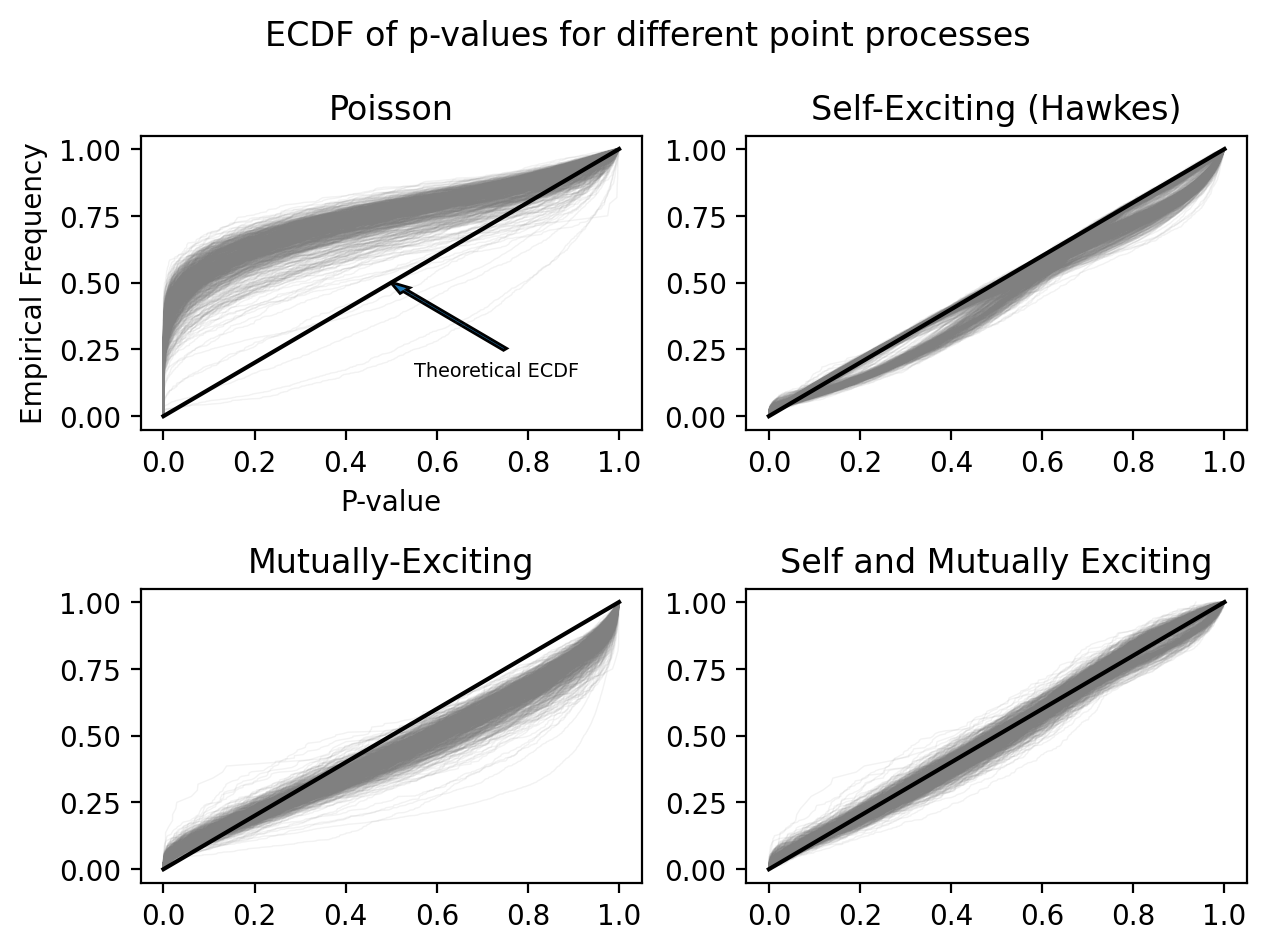

In [264]:
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(2, 2)
fig.suptitle('ECDF of p-values for different point processes')
plot_ecdf_M1()
plot_ecdf_M2()
plot_ecdf_M3()
plot_ecdf_M4()
plt.tight_layout()
plt.show()

### KS Boxplot

In [265]:
M1_ks_array = np.asarray(list(M1_ks_dict.values()))
M2_ks_array = np.asarray(list(M2_ks_dict.values()))
M3_ks_array = np.asarray(list(M3_ks_dict.values()))
M4_ks_array = np.asarray(list(M4_ks_dict.values()))
labels = ['Poisson', 'Self-Exciting\n(Hawkes)', 'Mutually-Exciting', 'Self-and-Mutually\nExciting']


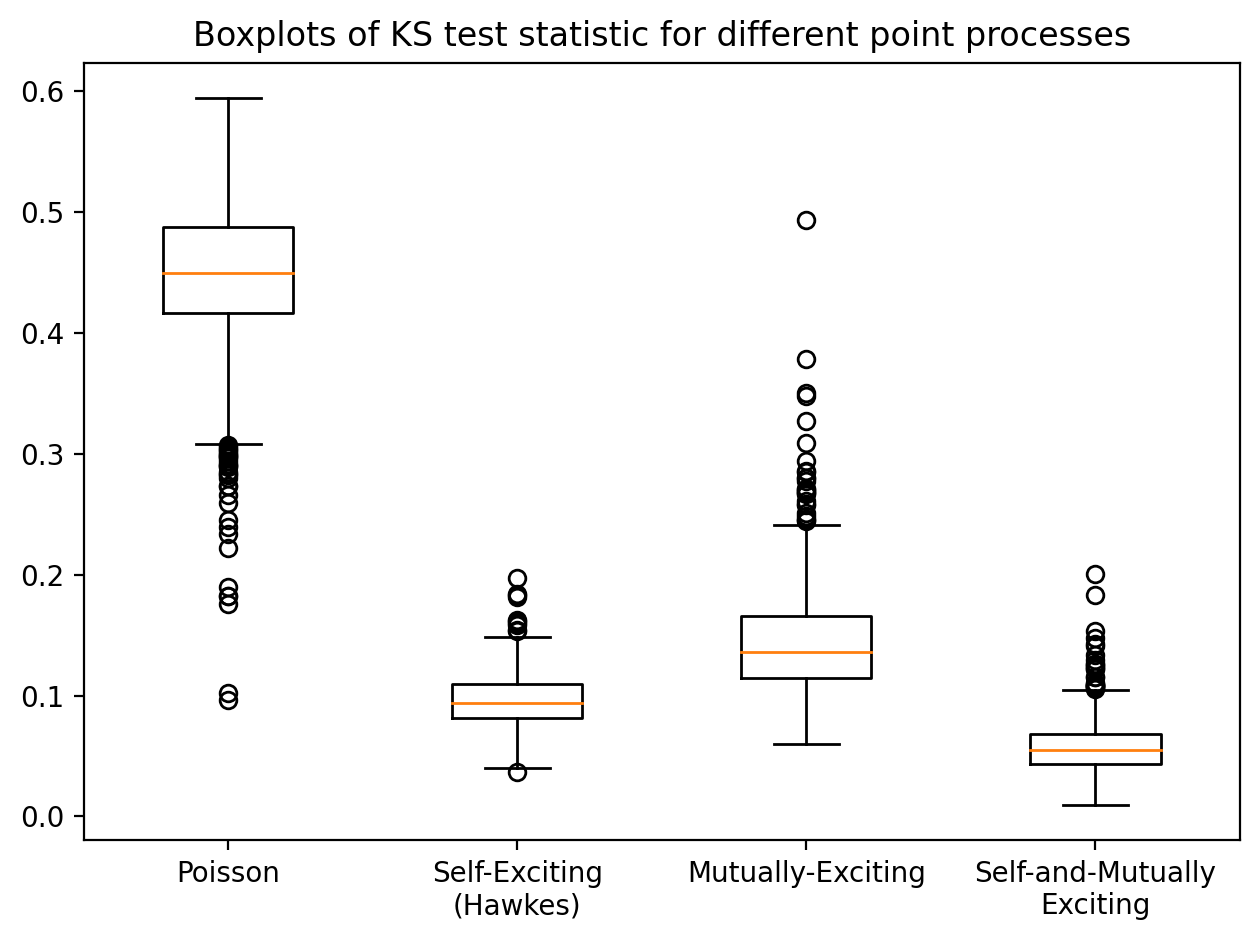

In [266]:
plt.boxplot([M1_ks_array, M2_ks_array, M3_ks_array, M4_ks_array], labels=labels)
plt.title("Boxplots of KS test statistic for different point processes")
plt.tight_layout()
plt.show()

### Joined p-value histogram

In [267]:
def lblFormat(n, pos):
    return str(int(n / 1e3))
lblFormatter = FuncFormatter(lblFormat)

In [268]:
def plot_M1_joined_p_value_hist():
    M1_joined_p_values = join_p_values(M1_p_value_dict)
    n1, bins, patches = axs[0, 0].hist(M1_joined_p_values, bins=100)
    ax = axs[0,0].get_yaxis()
    def lblFormat_M1(n1, pos):
        return str(int(n1 / 1e3))
    lblFormatter_M1 = FuncFormatter(lblFormat_M1)
    ax.set_major_formatter(lblFormatter_M1)
    axs[0, 0].set_title("Poisson")
    axs[0, 0].set_xlabel("P-value")
    axs[0, 0].set_ylabel("Count (Thousands)")

def plot_M2_joined_p_value_hist():
    M2_joined_p_values = join_p_values(M2_p_value_dict)
    n2, bins, patches = axs[0, 1].hist(M2_joined_p_values, bins=100)
    ax = axs[0,1].get_yaxis()
    def lblFormat_M2(n2, pos):
        return str(int(n2 / 1e3))
    lblFormatter_M2 = FuncFormatter(lblFormat_M2)
    ax.set_major_formatter(lblFormatter_M2)
    axs[0, 1].set_title("Self-Exciting (Hawkes)")

def plot_M3_joined_p_value_hist():
    M3_joined_p_values = join_p_values(M3_p_value_dict)
    n3, bins, patches = axs[1, 0].hist(M3_joined_p_values, bins=100)
    ax = axs[1,0].get_yaxis()
    def lblFormat_M3(n3, pos):
        return str(int(n3 / 1e3))
    lblFormatter_M3 = FuncFormatter(lblFormat_M3)
    ax.set_major_formatter(lblFormatter_M3)
    axs[1, 0].set_title("Mutually-Exciting")

def plot_M4_joined_p_value_hist():
    M4_joined_p_values = join_p_values(M4_p_value_dict)
    n4, bins, patches = axs[1, 1].hist(M4_joined_p_values, bins=100)
    ax = axs[1,1].get_yaxis()
    def lblFormat_M4(n4, pos):
        return str(int(n4 / 1e3))
    lblFormatter_M4 = FuncFormatter(lblFormat_M4)
    ax.set_major_formatter(lblFormatter_M4)
    axs[1, 1].set_title("Mutually and Self Exciting")

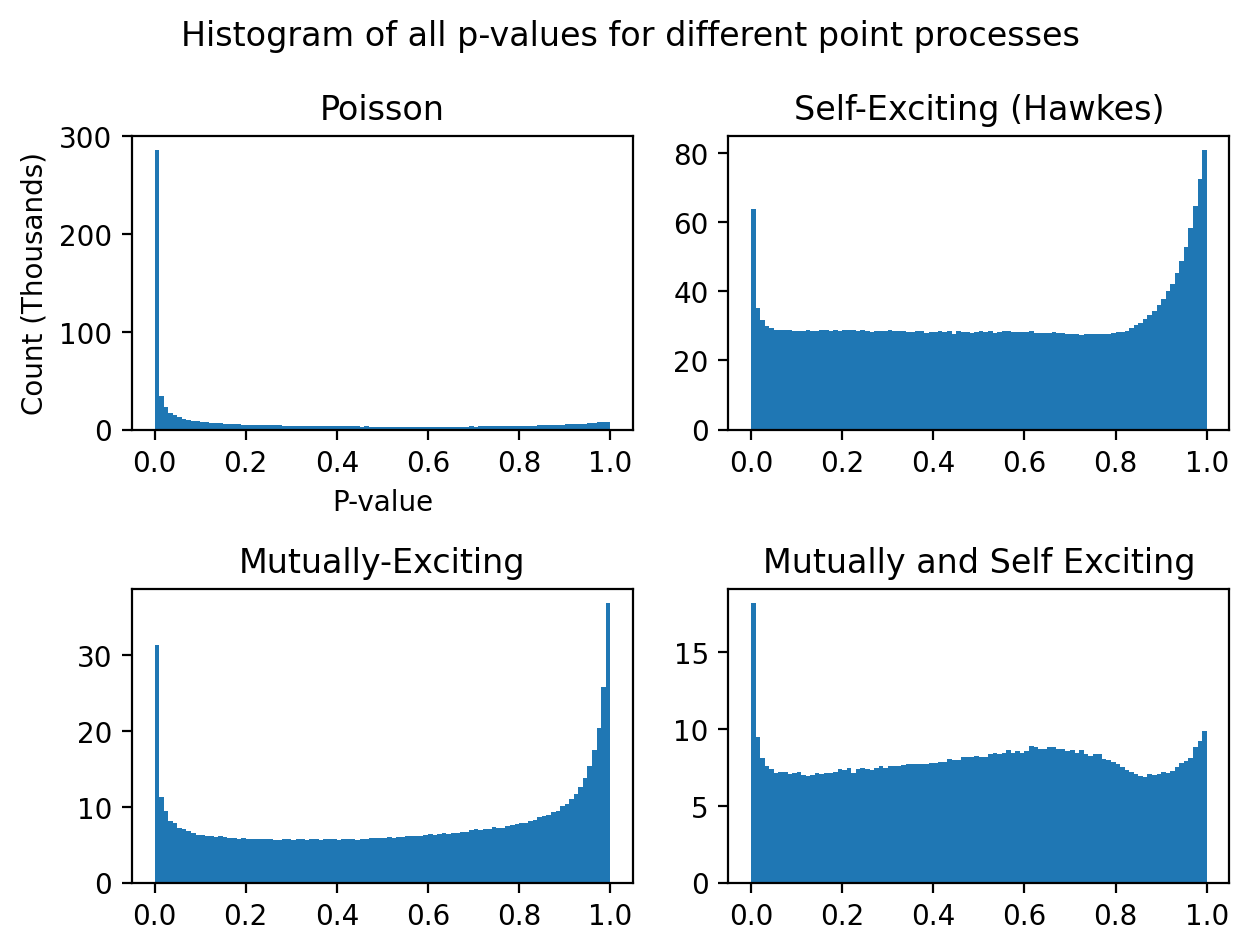

In [269]:
plt.rcParams['figure.dpi'] = 200
fig, axs = plt.subplots(2, 2)
fig.suptitle('Histogram of all p-values for different point processes')
plot_M1_joined_p_value_hist()
plot_M2_joined_p_value_hist()
plot_M3_joined_p_value_hist()
plot_M4_joined_p_value_hist()
plt.tight_layout()
plt.show()

### Popularity Scatter plots

In [283]:
M1_pop_array = np.asarray(list(M1_popularity_dict.values()))
M2_pop_array = np.asarray(list(M2_popularity_dict.values()))
M3_pop_array = np.asarray(list(M3_popularity_dict.values()))
M4_pop_array = np.asarray(list(M4_popularity_dict.values()))

In [281]:
m1, b1 = np.polyfit(M1_pop_array, M1_ks_array, 1)
m2, b2 = np.polyfit(M2_pop_array, M2_ks_array, 1)
m3, b3 = np.polyfit(M3_pop_array, M3_ks_array, 1)
m4, b4 = np.polyfit(M4_pop_array, M4_ks_array, 1)

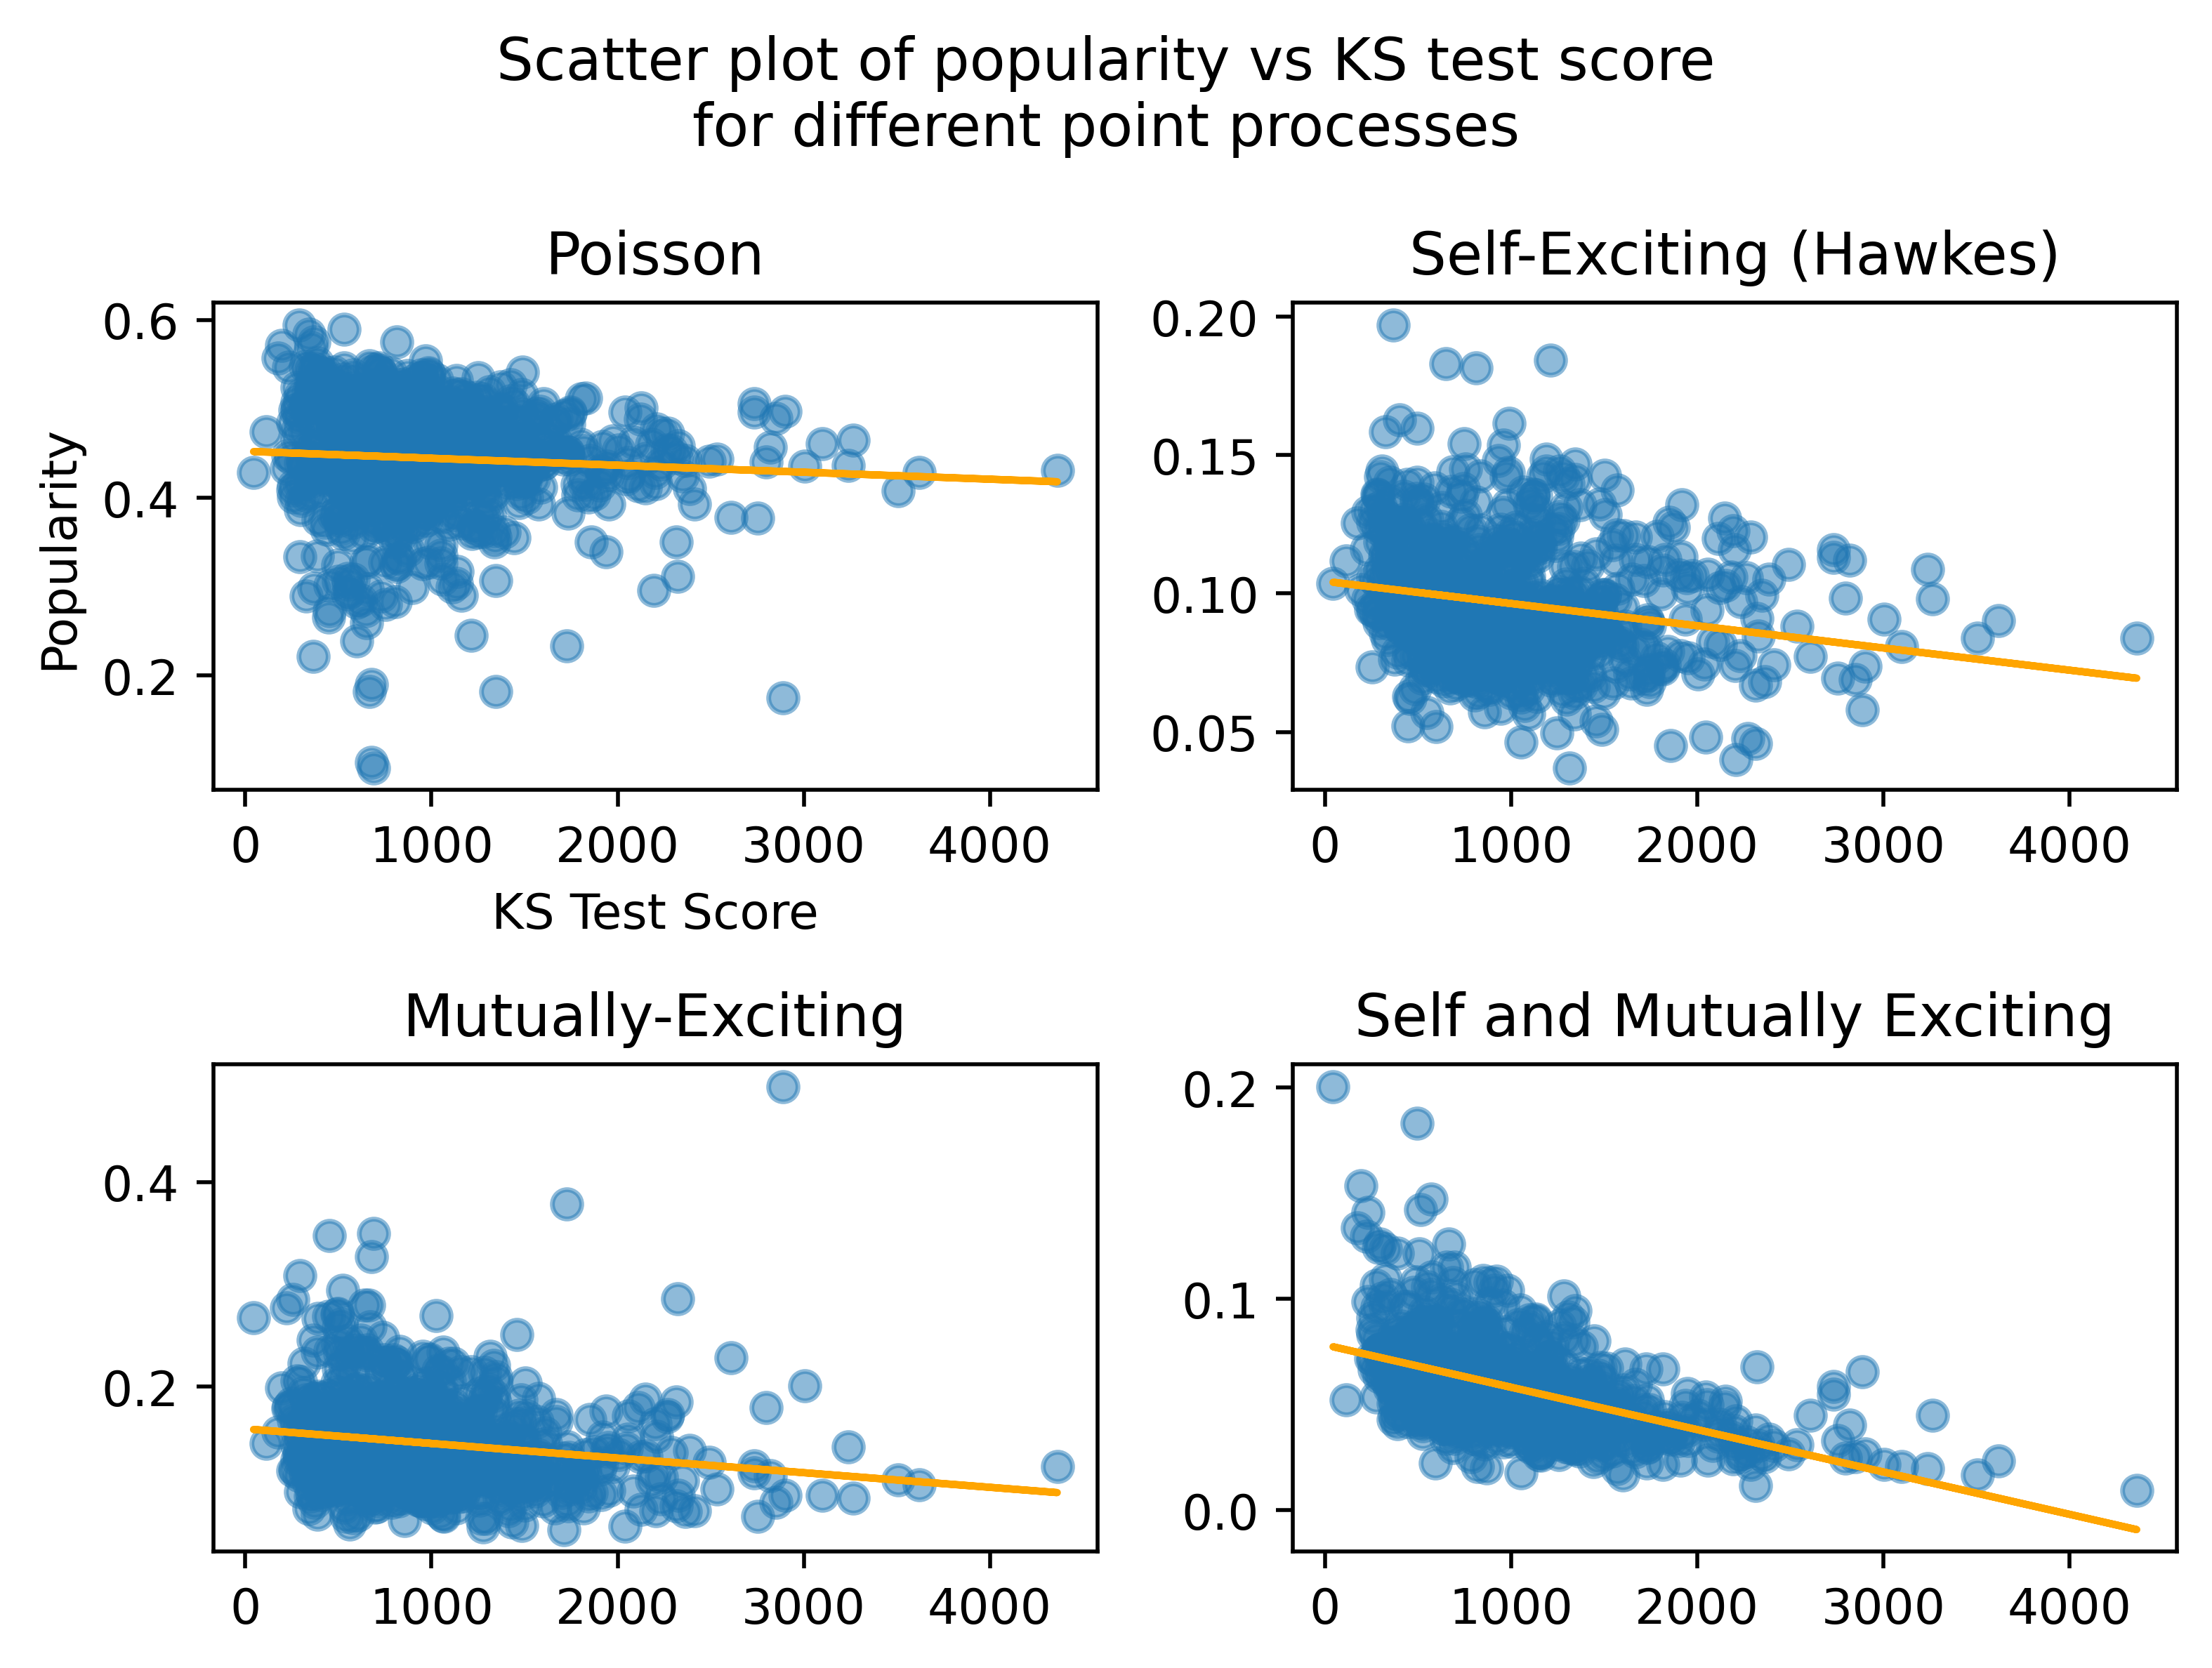

In [285]:
plt.rcParams['figure.dpi'] = 500
fig, axs = plt.subplots(2, 2)
fig.suptitle('Scatter plot of popularity vs KS test score\nfor different point processes')

axs[0, 0].set_title("Poisson")
axs[0, 0].set_xlabel("KS Test Score")
axs[0, 0].set_ylabel("Popularity")
axs[0, 0].scatter(M1_pop_array, M1_ks_array, alpha=0.5)
axs[0, 0].plot(M1_pop_array, m1*M1_pop_array + b1, color="orange")

axs[0, 1].set_title("Self-Exciting (Hawkes)")
axs[0, 1].scatter(M2_pop_array, M2_ks_array, alpha=0.5)
axs[0, 1].plot(M2_pop_array, m2*M2_pop_array + b2, color="orange")

axs[1, 0].set_title("Mutually-Exciting")
axs[1, 0].scatter(M3_pop_array, M3_ks_array, alpha=0.5)
axs[1, 0].plot(M3_pop_array, m3*M3_pop_array + b3, color="orange")

axs[1, 1].set_title("Self and Mutually Exciting")
axs[1, 1].scatter(M4_pop_array, M4_ks_array, alpha=0.5)
axs[1, 1].plot(M4_pop_array, m4*M4_pop_array + b4, color="orange")

plt.tight_layout()
plt.show()
